# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100
# InteractiveShell.ast_node_interactivity = "all"

## Handwritten digit recognition (5 points, 1+2+2)
The [MNIST dataset](https://www.openml.org/d/554) contains 70,000 images of handwritten digits (0-9) represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '11e82c8d91c5abece86f424369c71590'

Class label: 5


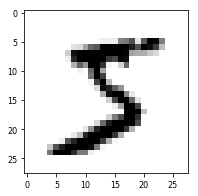

In [3]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); # Get the predictors X and the labels y
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.gray_r) # Take the first example, reshape to a 28x28 image and plot
print("Class label:",y[0]) # Print the correct class label

- Evaluate a k-Nearest Neighbor classifier with its default settings.
    - Use the first 60,000 examples as the training set and the last 10,000 as the test set
    - What is the predictive accuracy?
    - Find a few misclassifications, and plot them together with the true labels (as above). Are these images really hard to classify?
- Optimize the value for the number of neighbors $k$ (keep $k$ < 50) on a stratified subsample (e.g. 10%) of the data
    - Use 10-fold crossvalidation and plot $k$ against the misclassification rate. Which value of $k$ should you pick?
    - Do the same but with 100 bootstrapping repeats. Are the results different? Explain.
- Compare kNN against the linear classification models that we have covered in the course (logistic regression and linear SVMs).
    - First use the default hyperparameter settings.
    - Next, optimize for the degree of regularization ($C$) and choice of penalty (L1/L2). Again, plot the accuracy while increasing the degree of regularization for different penalties. Interpret the results. 
    - Report is the optimal performance. Can you get better results than kNN?
    
Report all results clearly and interpret the results.  
Note: while prototyping/bugfixing, you can speed up experiments by taking a smaller sample of the data, but report your results as indicated above.

In [6]:
# Initialize
from sklearn import neighbors, linear_model
import math

dataSize = 70000
split = 60000/dataSize
percentage = 0.01
numElements = int(percentage*dataSize)
testSize = int(percentage*dataSize*split)

Learning on 700 elements with 600 test size


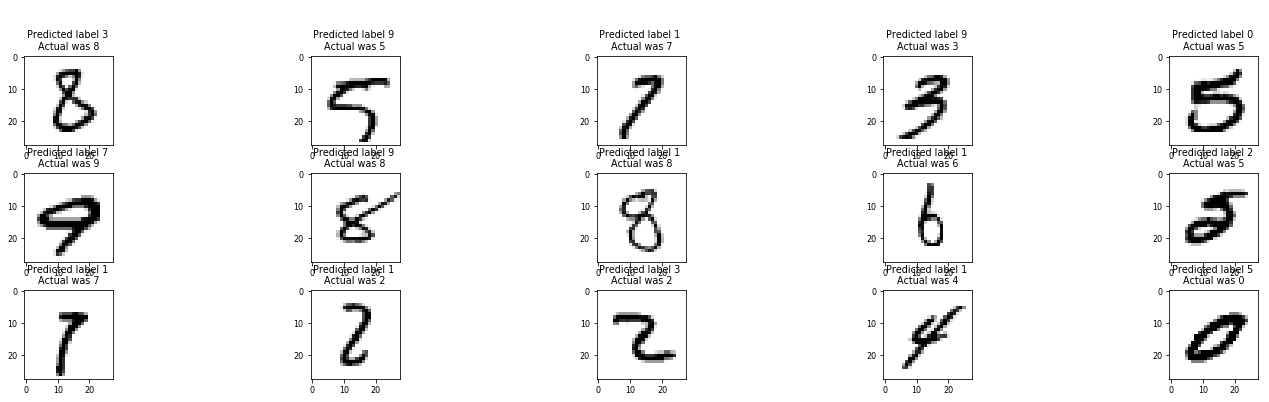

In [7]:
# Goal: Evaluating a k-Nearest neighbor classifier
print("Learning on %i elements with %i test size" % (numElements, testSize))

# The number of invalid samples to plot
samples = 15

# Split 60.000/10.000 for both the predictors and labels
X_train, X_test = np.split(X[:numElements],[testSize])
y_train, y_test = np.split(y[:numElements],[testSize])

# Initialize knn with default values
knn = neighbors.KNeighborsClassifier()

# Fit knn to training data
knn.fit(X_train, y_train)

# Use knn to predict test data
y_pred = knn.predict(X_test)

# Print predictive accuracy
#print('Predictive accuracy: %f' % knn.fit(X_train, y_train).score(X_test, y_test))

# Print {samples} amount of figures with wrong results
# print (samples / 5, math.floor(samples / 5))
fig, axes = plt.subplots(math.floor(samples / 5), 5, figsize=(20, 5))
plt.tight_layout() 
sample = 0
i = 0
while sample < samples or i > len(y_pred):
    if (y_pred[i] != y_test[i]):
        axes[math.floor(sample / 5)][sample % 5].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray_r)
        axes[math.floor(sample / 5)][sample % 5].set_title("\n\nPredicted label {} \nActual was {}".format(y_pred[i], y_test[i]))
        sample += 1
    i+=1
    
plt.show()

In [41]:
# Optimizing value for k neighbors

In [27]:
# Comparing kNN to others

## Model selection (4 points (2+2))
Study how RandomForest hyperparameters interact on the Ionosphere dataset (OpenML ID 59).

- Optimize a RandomForest, varying both $n\_estimators$ and $max\_features$ at the same time. Use a nested cross-validation and a grid search (or random search) over the possible values, and measure the AUC. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal AUC performance you find?
- Again, vary both hyperparameters, but this time use a grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow AUC$ with AUC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

Hint: Running this experiment can take a while, so start early and use a feasible grid/random search. Start with a coarse grid or few random search iterations.
Hint: Use a log scale (1,2,4,8,16,...) for $n\_estimators$. Vary $max\_features$ linearly between 1 and the total number of features. Note that, if you give $max\_features$ a float value, it will use it as [the percentage of the total number of features](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


In [ ]:
ionosphere = oml.datasets.get_dataset(59) # Download Ionosphere data
X, y = ionosphere.get_data(target=ionosphere.default_target_attribute); # Get the predictors X and the labels y

## Decision tree heuristics (1 point)
Consider the toy training set created below. It predicts whether your date agrees to go out with you depending on the weather.

Learn a decision tree:

- Implement functions to calculate entropy and information gain
- What is the class entropy for the entire dataset? What is the information gain when you split the data using the *Water* feature?
- Implement a basic decision tree:
    - Select a feature to split on according to its information gain. If multiple features are equally good, select the leftmost one.
    - Split the data and repeat until the tree is complete.
    - Print out the results (nodes and splits).
- Now train a scikit-learn decision tree on the same data. Do you get the same result? Explain.

In [6]:
df = pd.DataFrame({"Sky":['sunny','sunny','rainy','sunny','sunny'],
                   "AirTemp":['warm','warm','warm','cold','warm'],
                   "Humidity":['normal','high','high','high','normal'],
                   "Wind":['strong','strong','strong','strong','weak'],
                   "Water":['warm','warm','cool','warm','warm'],
                   "Forecast":['same','same','change','change','same'],
                   "Date?":['yes','yes','no','yes','no']
                   });
df = df[['Sky', 'AirTemp', 'Humidity', 'Wind', 'Water', 'Forecast', 'Date?']] # Fix column ordering
df # print

,Sky,AirTemp,Humidity,Wind,Water,Forecast,Date?
0,sunny,warm,normal,strong,warm,same,yes
1,sunny,warm,high,strong,warm,same,yes
2,rainy,warm,high,strong,cool,change,no
3,sunny,cold,high,strong,warm,change,yes
4,sunny,warm,normal,weak,warm,same,no


In [ ]:
# Complete these functions first
def entropy(pos, neg):
    return 0

def info_gain(pos1,neg1,pos2,neg2):
    return 0

## Random Forests (4 points (1+1+2))
Study the effect of the number of trees in a RandomForest on the EEG-eye-state dataset (http://www.openml.org/d/1471). This dataset measures brain activity using 15 sensors, and you need to predict whether the person's eyes are open or closed. 

* Train a RandomForest classifier on this dataset with an increasing number of trees (on a log scale as above). Plot the Out-Of-Bag error against the number of trees.
    - The Out-Of-Bag error is the test error obtained when using bootstrapping, and using the non-drawn data points as the test set. This is what a RandomForest does internally, so you can retrieve it from the classifier. The code below hints on how to do this.
* Construct the same plot, but now use 10-fold Cross-validation and error rate instead of the OOB error. Compare the two. What do you learn from this?
* Compare the performance of the RandomForest ensemble with that of a single full decision tree. Compute the AUC as well as the bias and variance. Does the bias and variance increase/decrease for the ensemble? Does the number of trees affect the result?

Hint: Error rate = 1 - accuracy  
Hint: We discussed bias-variance decomposition in class. It is not included in scikit-learn, so you'll need to implement it yourself.

In [ ]:
eeg = oml.datasets.get_dataset(1471) # Download Ionosphere data
X, y = eeg.get_data(target=eeg.default_target_attribute);

# Out of bag errors can be retrieved from the RandomForest classifier. You'll need to loop over the number of trees.
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from sklearn import ensemble
clf = ensemble.RandomForestClassifier()
clf.fit(X, y)
(1 - clf.oob_score)

## A regression benchmark (1 point)
Consider the liver-disorder dataset (http://www.openml.org/d/8). The goal is to predict how much alcohol someone consumed based on blood test values.

- Take a selection of the algorithms that we covered in class that can do regression.
- Based on what you learned in the previous exercises, make educated guesses about good hyperparameter values and set up a grid or random search.
- Evaluate all models with 10-fold cross-validation and root mean squared error (RMSE). Report all results. Which model yields the best results?

In [ ]:
liver = oml.datasets.get_dataset(8) # Download Liver-disorders data
X, y = liver.get_data(target=liver.default_target_attribute);